# Analyze generic genes and pathways

This notebook uses the DEG and GSEA statistics obtained from the previous notebooks [3_gene_DE_analysis](3_gene_DE_analysis.ipynb) and [4_pathway enrichment analysis](4_pathway_enrichment_analysis.ipynb) to: 
1. Determine if our simulation approach can identify a set of generic genes and pathways
2. Compare our set of generic genes and pathways with what has been previously reported

In [1]:
%load_ext autoreload
%load_ext rpy2.ipython
%autoreload 2

import os
import sys
import pandas as pd
import numpy as np
import random
import warnings
import rpy2.robjects
import seaborn as sns

from plotnine import (ggplot,
                      labs,   
                      geom_point,
                      aes, 
                      ggsave, 
                      theme_bw,
                      theme,
                      xlim,
                      ylim,
                      facet_wrap,
                      scale_color_manual,
                      guides, 
                      guide_legend,
                      element_blank,
                      element_text,
                      element_rect,
                      element_line,
                      coords)

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

sys.path.append("../")
from functions import utils

from numpy.random import seed
randomState = 123
seed(randomState)

/home/alexandra/anaconda3/envs/ranked_pathways/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../"))

config_file = os.path.abspath(os.path.join(base_dir,
                                           "Rank_pathways",
                                           "init_config.tsv"))
params = utils.read_config(config_file)

In [3]:
# Load params
local_dir = params["local_dir"]

In [4]:
# Input files
gene_summary_file = os.path.join(
    local_dir, 
    "gene_summary_table.tsv")

pathway_summary_file = os.path.join(
    local_dir, 
    "pathway_summary_table.tsv")

## Generic genes

### Map gene ids
Our gene ids are ensembl while the published gene ids are using hgnc symbols. We need to map ensembl to hgnc ids in order to compare results.

In [5]:
%%R
suppressWarnings(library("biomaRt"))

In [6]:
%%R -i gene_summary_file -o gene_id_mapping
# Convert gene ids from ensembl (ours) to entrez (DE_prior)

source('../functions/GSEA_analysis.R')

gene_id_mapping <- get_ensembl_symbol_mapping(gene_summary_file)

/home/alexandra/anaconda3/envs/ranked_pathways/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Cache found

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/ranked_pathways/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


In [7]:
# Set ensembl id as index
gene_id_mapping.set_index("ensembl_gene_id", inplace=True)
print(gene_id_mapping.shape)
gene_id_mapping.head()

(57210, 1)


,hgnc_symbol
ensembl_gene_id,
ENSG00000002330,BAD
ENSG00000003137,CYP26B1
ENSG00000003249,DBNDD1
ENSG00000004799,PDK4
ENSG00000006062,MAP3K14


In [8]:
# Replace ensembl ids with gene symbols
# Only replace if ensembl ids exist
if gene_id_mapping.shape[0] > 0:
    utils.replace_ensembl_ids(gene_summary_file,
                          gene_id_mapping)

### Our DEGs
Genes are ranked by their adjusted p-value and the median rank reported across 25 simulated experiments is shown in column `Median rank (simulated)`.

In [9]:
# Read data
gene_stats = pd.read_csv(
    gene_summary_file,
    header=0,
    sep='\t',
    index_col=0)
print(gene_stats.shape)
gene_stats.head()

(38782, 10)


,Gene ID,Adj P-value (Real),Rank (Real),Test statistic (Real),Median adj p-value (simulated),Median rank (simulated),Mean test statistic (simulated),Std deviation (simulated),Number of experiments (simulated),Z score
HYOU1,ENSG00000149428.18,0.0,58035.0,17.87831,0.00000,50804.0,8.58920,6.64357,25,1.39821
P4HB,ENSG00000185624.14,0.0,58024.0,15.50334,0.00367,28321.0,1.89574,4.26930,25,3.18731
ISCA2,ENSG00000165898.13,0.0,58021.0,15.02415,0.00000,55555.0,10.37021,2.94420,25,1.58071
CRABP2,ENSG00000143320.8,0.0,58018.0,14.61660,0.00629,29291.0,3.05728,2.24636,25,5.14580
ALDH18A1,ENSG00000059573.8,0.0,58015.0,14.49881,0.00000,54537.0,9.34094,4.70813,25,1.09553


In [11]:
# Get list of our genes
gene_ids = list(gene_stats.index)

### Published DEGs
These DEGs are based on the [Crow et. al. publication](https://www.pnas.org/content/pnas/116/13/6491.full.pdf). Their genes are ranked 0 = not commonly DE; 1 = commonly DE. Genes by the number differentially expressed gene sets they appear in and then ranking genes by this score.

In [12]:
# Get generic genes identified by Crow et. al.
DE_prior_file = "https://raw.githubusercontent.com/maggiecrow/DEprior/master/DE_Prior.txt"

DE_prior = pd.read_csv(DE_prior_file,
                       header=0,
                       sep="\t")

DE_prior.head()

,Gene_Order,Gene_EntrezID,N_HitLists,DE_Prior_Rank,Gene_Name
0,1,7503,79,1.000000,XIST
1,2,8653,64,0.999948,DDX3Y
2,3,9086,62,0.999870,EIF1AY
3,4,8284,52,0.999870,KDM5D
4,5,8287,46,0.999791,USP9Y


In [13]:
# Get list of published generic genes
published_generic_genes = list(DE_prior['Gene_Name'])

### Compare DEG ranks

In [15]:
# Get intersection of gene lists
shared_genes = set(gene_ids).intersection(published_generic_genes)
print(len(shared_genes))

17787


In [25]:
# Get genes only in ours not theirs
our_unique_genes = set(gene_ids) - set(shared_genes)
print(len(our_unique_genes))
our_unique_genes

20115


{nan,
 'SNORD115-29',
 'KRT18P13',
 'HMGB1P26',
 'KARS1P2',
 'CYP3A51P',
 'THAP5P1',
 'MTCO2P23',
 'RNU6-434P',
 'RNU6-37P',
 'RNU4-72P',
 'RPS3AP49',
 'KRT18P45',
 'RLIMP2',
 'PLA2G2C',
 'LINC00355',
 'RN7SL715P',
 'LINC01038',
 'LINC01480',
 'RN7SKP112',
 'FAM90A21P',
 'RPS15AP40',
 'CUBNP2',
 'LINC01443',
 'RNU6-207P',
 'PEX5L-AS1',
 'NCOR1P3',
 'RPSAP48',
 'KRTAP5-11',
 'OR51F3P',
 'PPIAP68',
 'AGAP13P',
 'ZNF90P1',
 'HNRNPA1P1',
 'MRPL49P2',
 'RNU6-930P',
 'CYCSP2',
 'NPM1P22',
 'LINC00379',
 'IRX6',
 'POTEE',
 'GDF1',
 'PGBD4P5',
 'ARPP19P1',
 'LINC02374',
 'RPL35A',
 'RN7SL587P',
 'MTCO3P22',
 'LINC00411',
 'OR5M6P',
 'STAG3L5P-PVRIG2P-PILRB',
 'LINC01275',
 'SPDYC',
 'RN7SL481P',
 'MTND4P11',
 'ATP5MC2P3',
 'RN7SL408P',
 'DPRXP1',
 'RNU7-66P',
 'MFSD4BP1',
 'SCGB1D5P',
 'KRT19P6',
 'RN7SL38P',
 'DNAJB5-DT',
 'KIRREL1-IT1',
 'BPTFP1',
 'MARCHF11',
 'GTF2IP7',
 'PMS2P6',
 'ATP6V0CP2',
 'LINC01764',
 'RNU6-1257P',
 'MIR548AJ2',
 'NSA2P4',
 'RN7SL789P',
 'HNRNPA1P64',
 'LINC01043',

In [16]:
# Get rank of intersect genes
our_gene_rank_df = pd.DataFrame(gene_stats.loc[shared_genes,'Median rank (simulated)'])
print(our_gene_rank_df.shape)
our_gene_rank_df.head()

(17810, 1)


,Median rank (simulated)
LMOD2,31522.0
PYGO1,11644.0
LINC00880,46226.0
AP2M1,35728.0
MYOM3,25216.0


In [17]:
# Merge published ranking
shared_gene_rank_df = pd.merge(our_gene_rank_df,
                                        DE_prior[['DE_Prior_Rank','Gene_Name']],
                                        left_index=True,
                                        right_on='Gene_Name')

shared_gene_rank_df.set_index('Gene_Name', inplace=True)
print(shared_gene_rank_df.shape)
shared_gene_rank_df.head()

(17810, 2)


,Median rank (simulated),DE_Prior_Rank
Gene_Name,,
LMOD2,31522.0,0.355571
PYGO1,11644.0,0.435635
LINC00880,46226.0,0.327092
AP2M1,35728.0,0.635875
MYOM3,25216.0,0.328787


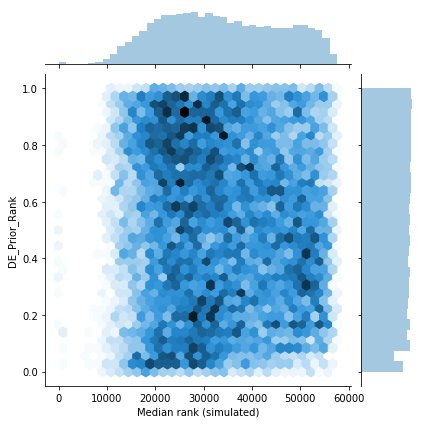

In [19]:
sns.jointplot(data=shared_gene_rank_df,
              x='Median rank (simulated)',
              y='DE_Prior_Rank',
             kind='hex')

# Make prettier if better way to show it

/home/alexandra/anaconda3/envs/ranked_pathways/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


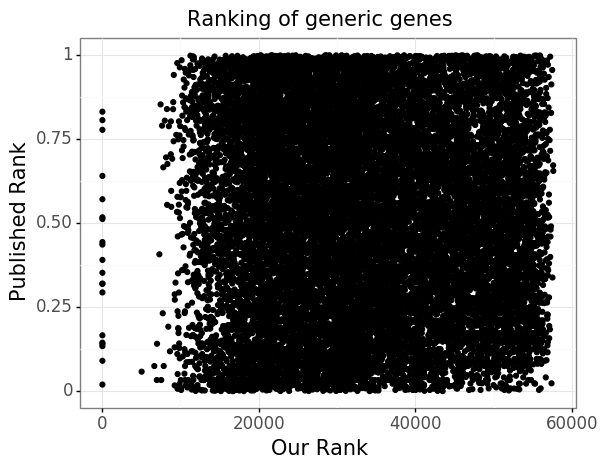

<ggplot: (8729816315561)>


In [20]:
# Plot our rank vs their rank on shared genes
fig = ggplot(shared_gene_rank_df, aes(x='Median rank (simulated)', y='DE_Prior_Rank'))
fig += geom_point()
fig += labs(x ='Our Rank',
            y = 'Published Rank',
            title = 'Ranking of generic genes')
fig += theme_bw()
fig += theme(
    legend_title_align = "center",
    plot_background=element_rect(fill='white'),
    legend_key=element_rect(fill='white', colour='white'), 
    legend_title=element_text(family='sans-serif', size=15),
    legend_text=element_text(family='sans-serif', size=12),
    plot_title=element_text(family='sans-serif', size=15),
    axis_text=element_text(family='sans-serif', size=12),
    axis_title=element_text(family='sans-serif', size=15)
    )

print(fig)

## Generic pathways

In [21]:
"""
# Read data
pathway_stats = pd.read_csv(
    pathway_summary_file,
    header=0,
    sep='\t',
    index_col=0)

pathway_stats.head()"""

"\n# Read data\npathway_stats = pd.read_csv(\n    pathway_summary_file,\n    header=0,\n    sep='\t',\n    index_col=0)\n\npathway_stats.head()"

In [22]:
"""# Define what are the set of generic genes
generic_pathway_data = pathway_stats.sort_values(by="Z score", ascending=True)[0:10]

generic_pathway_data.head()"""

'# Define what are the set of generic genes\ngeneric_pathway_data = pathway_stats.sort_values(by="Z score", ascending=True)[0:10]\n\ngeneric_pathway_data.head()'

In [23]:
# Manually compare against Powers et. al publication 
# https://academic.oup.com/bioinformatics/article/34/13/i555/5045793